In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re 
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt
from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv('../PYTHON PROJECT - Customer Segmentation/data/OnlineRetail (1).csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.shape

(541909, 8)

In [5]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# EDA and Feature Engineering

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [13]:
#---------------------------------------------------------------------------------------------------------
# Separating Invoice Date and Time
#---------------------------------------------------------------------------------------------------------

df['Date'] = df['InvoiceDate'].dt.date
df['Time'] = df['InvoiceDate'].dt.time

df.drop(columns=['InvoiceDate'], inplace=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


Invoice Number 

In [20]:
#----------------------------------------------------------------------------------------------------
# 'C' in the Invoice represents Cancellation. 
#  Creating a categorical column to represent Invoice status 
#----------------------------------------------------------------------------------------------------

df['Cancelled'] = df['InvoiceNo'].apply(
    lambda x :re.findall(r'[A-Z]', str(x))).apply(lambda x: pd.Series(x))


In [24]:
df['InvoiceNo'] = df['InvoiceNo'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

In [28]:
df['Cancelled'] = df['Cancelled'].astype('category')
df['Cancelled'].unique()

[NaN, 'C', 'A']
Categories (2, object): ['A', 'C']

In [29]:
#------------------------------------------------------------------------------------------------
# Function to filter rows based on Custom filters
#------------------------------------------------------------------------------------------------

def filter_rows(df, column, filter, criterion='equal'):
    
    if criterion == 'equal':
        return df[df[column]  == filter]
        
    if criterion == 'greater':
        return df[df[column] > filter]
        
    if criterion == 'lesser':
        return df[df[column] < filter]
    

In [31]:
filter_rows(df, column='Cancelled', filter='A', criterion='equal')

df = df[df['Cancelled']!='A']

In [37]:
df['Cancelled'] = df['Cancelled'].cat.add_categories([0])

df['Cancelled'].fillna(value=0, inplace=True)
df['Cancelled'].replace({'C': 1}, inplace=True)


C:\Users\R.Yeshasvin\AppData\Local\Temp\ipykernel_26196\2364795512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cancelled'].fillna(value=0, inplace=True)
C:\Users\R.Yeshasvin\AppData\Local\Temp\ipykernel_26196\2364795512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cancelled'].replace({'C': 1}, inplace=True)


Stock Code

In [43]:
df.nunique()

InvoiceNo      25897
StockCode       4069
Description     4222
Quantity         722
UnitPrice       1628
CustomerID      4372
Country           38
Date             305
Time             774
Cancelled          2
dtype: int64

In [44]:
#----------------------------------------------------------------------------------------------
# Stock code is a uniquue identifier assigned to each item. Therefore it can be considered Cateforical
#----------------------------------------------------------------------------------------------

df['StockCode'] = df['StockCode'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541906 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    541906 non-null  object  
 1   StockCode    541906 non-null  category
 2   Description  540452 non-null  object  
 3   Quantity     541906 non-null  int64   
 4   UnitPrice    541906 non-null  float64 
 5   CustomerID   406829 non-null  float64 
 6   Country      541906 non-null  object  
 7   Date         541906 non-null  object  
 8   Time         541906 non-null  object  
 9   Cancelled    541906 non-null  category
dtypes: category(2), float64(2), int64(1), object(5)
memory usage: 38.9+ MB


Unit Price 

In [45]:
df['TotalAmount'] = df['UnitPrice']*df['Quantity']

In [47]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount
count,541906.000000,541906.000000,406829.000000,541906.000000
mean,9.552297,4.631552,15287.690570,18.008308
std,218.081761,93.192775,1713.600303,377.915677
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [48]:
#-------------------------------------------------------------------------------------------------
# Columns with 0 Total Amount
#-------------------------------------------------------------------------------------------------

filter_rows(df, 'TotalAmount', filter=0, criterion='equal')

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount
622,536414,22139,NaN,56,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0,0.0
1970,536545,21134,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0,0.0
1971,536546,22145,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,0.0
1972,536547,37509,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,0.0
1987,536549,85226A,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,0.0,NaN,United Kingdom,2011-12-08,10:33:00,0,0.0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,0.0,NaN,United Kingdom,2011-12-08,13:58:00,0,0.0
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,0.0,NaN,United Kingdom,2011-12-08,13:58:00,0,0.0
538554,581408,85175,NaN,20,0.0,NaN,United Kingdom,2011-12-08,14:06:00,0,0.0


In [50]:
df = df[df['TotalAmount'] !=0]
df.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount
count,539391.000000,539391.000000,406789.000000,539391.000000
mean,9.845921,4.653148,15287.795830,18.092274
std,215.412851,93.409248,1713.573064,378.793696
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,3.750000
50%,3.000000,2.080000,15152.000000,9.840000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [54]:
#-------------------------------------------------------------------------------------------------
# Columns with Negative Total Amount
#-------------------------------------------------------------------------------------------------
negative_total = filter_rows(df, 'TotalAmount', filter=0 , criterion='lesser')
negative_total

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount
141,536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,-27.50
154,536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,-4.65
235,536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,-19.80
236,536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,-6.96
237,536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
540449,581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011-12-09,09:57:00,1,-9.13
541541,581499,M,Manual,-1,224.69,15498.0,United Kingdom,2011-12-09,10:28:00,1,-224.69
541715,581568,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011-12-09,11:57:00,1,-54.75
541716,581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315.0,United Kingdom,2011-12-09,11:58:00,1,-1.25


In [56]:
negative_total['Cancelled'].value_counts()

Cancelled
1    9288
A       0
0       0
Name: count, dtype: int64

In [61]:
# Checking to see if there are cancelled orders with negative total amount 

df[(df['TotalAmount'] <0) & (df['Cancelled'] == 0)]



,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount


Description

In [64]:
df['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'LETTER "U" BLING KEY RING',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

Quantity

In [66]:
df['Quantity'].nunique()

510

In [67]:
df['Quantity'].describe()

count    539391.000000
mean          9.845921
std         215.412851
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [70]:
negative_quantity = filter_rows(df, 'Quantity', filter=0, criterion='lesser')
negative_quantity.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount
141,536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,-27.50
154,536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,-4.65
235,536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,-19.80
236,536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,-6.96
237,536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,-6.96


In [72]:
negative_quantity['Cancelled'].value_counts()

# It appears that the Cancelled orders have negative values for quantities

Cancelled
1    9288
A       0
0       0
Name: count, dtype: int64

Customer Id

In [73]:
df['CustomerID'].nunique()

4371

In [74]:
df['CustomerID'].isnull().sum()

132602

In [82]:
df[(df['CustomerID'].isna()) & (df['Cancelled'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount
11502,537251,22429,ENAMEL MEASURING JUG CREAM,-2,4.25,NaN,United Kingdom,2010-12-06,10:45:00,1,-8.50
11503,537251,22620,4 TRADITIONAL SPINNING TOPS,-8,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,-10.00
11504,537251,21890,S/6 WOODEN SKITTLES IN COTTON BAG,-2,2.95,NaN,United Kingdom,2010-12-06,10:45:00,1,-5.90
11505,537251,22564,ALPHABET STENCIL CRAFT,-5,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,-6.25
11506,537251,21891,TRADITIONAL WOODEN SKIPPING ROPE,-3,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,-3.75
...,...,...,...,...,...,...,...,...,...,...,...
492207,578097,22112,CHOCOLATE HOT WATER BOTTLE,-48,4.25,NaN,United Kingdom,2011-11-22,17:31:00,1,-204.00
514984,579757,47469,ASSORTED SHAPES PHOTO CLIP SILVER,-24,0.65,NaN,United Kingdom,2011-11-30,14:56:00,1,-15.60
516454,579907,22169,FAMILY ALBUM WHITE PICTURE FRAME,-2,7.65,NaN,EIRE,2011-12-01,08:48:00,1,-15.30
524601,580604,AMAZONFEE,AMAZON FEE,-1,11586.50,NaN,United Kingdom,2011-12-05,11:35:00,1,-11586.50


In [83]:
df[(df['CustomerID'].isna()) & (df['Cancelled'] == 0)]


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,2.51
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,5.02
1445,536544,21786,POLKADOT RAIN HAT,4,0.85,NaN,United Kingdom,2010-12-01,14:32:00,0,3.40
1446,536544,21787,RAIN PONCHO RETROSPOT,2,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,3.32
1447,536544,21790,VINTAGE SNAP CARDS,9,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,14.94
...,...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,4.13,NaN,United Kingdom,2011-12-09,10:26:00,0,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,NaN,United Kingdom,2011-12-09,10:26:00,0,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,NaN,United Kingdom,2011-12-09,10:26:00,0,4.96
541539,581498,85174,S/4 CACTI CANDLES,1,10.79,NaN,United Kingdom,2011-12-09,10:26:00,0,10.79


In [87]:
#----------------------------------------------------------------------------------------------
# 25% of the values from Customer ID column are NUll. This can be due to single purchases without am membership i.e no 
#  customer retention or future potential. Hence the anonymous customers will not be considered
#----------------------------------------------------------------------------------------------

df = df[pd.notnull(df['CustomerID'])]

df.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount
count,406789.000000,406789.000000,406789.000000,406789.000000
mean,12.028359,3.460811,15287.795830,20.403860
std,247.927842,69.318561,1713.573064,427.612692
min,-80995.000000,0.001000,12346.000000,-168469.600000
25%,2.000000,1.250000,13954.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


Country

In [94]:
df['Country'].value_counts().keys()

#----------------------------------------------------------------------------------------------------
# EIRE represents Ireland
# RSA represents South Africa 
# The unspepcified values will is assigned to the mode country ie 'United Kingdom'
#----------------------------------------------------------------------------------------------------


Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Netherlands',
       'Belgium', 'Switzerland', 'Portugal', 'Australia', 'Norway', 'Italy',
       'Channel Islands', 'Finland', 'Cyprus', 'Sweden', 'Austria', 'Denmark',
       'Japan', 'Poland', 'USA', 'Israel', 'Unspecified', 'Singapore',
       'Iceland', 'Canada', 'Greece', 'Malta', 'United Arab Emirates',
       'European Community', 'RSA', 'Lebanon', 'Lithuania', 'Brazil',
       'Czech Republic', 'Bahrain', 'Saudi Arabia'],
      dtype='object', name='Country')

In [95]:
df.replace(
    {'EIRE': 'Ireland',
     'RSA': 'South Africa',
     'USA': 'United States',
     'Unspecified': 'United Kingdom'
    }, inplace=True)

df['Country'] = df['Country'].astype('category')


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406789 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    406789 non-null  object  
 1   StockCode    406789 non-null  category
 2   Description  406789 non-null  object  
 3   Quantity     406789 non-null  int64   
 4   UnitPrice    406789 non-null  float64 
 5   CustomerID   406789 non-null  float64 
 6   Country      406789 non-null  category
 7   Date         406789 non-null  object  
 8   Time         406789 non-null  object  
 9   Cancelled    406789 non-null  category
 10  TotalAmount  406789 non-null  float64 
dtypes: category(3), float64(3), int64(1), object(4)
memory usage: 29.6+ MB


# COHORT ANALYSIS 

## Creating Time Cohorts 

In [109]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [110]:
df['InvoiceMonth'] = df['Date'].apply(get_month)

In [111]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01


In [118]:
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01


In [119]:
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    
    return year, month, day

In [120]:
invoice_year, invoice_month, invoice_day = get_date(df, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date(df, 'CohortMonth')

In [121]:
years_diff = invoice_year-cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

df['CohortIndex'] = (years_diff*12 + months_diff+1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Cancelled,TotalAmount,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,20.34,2010-12-01,2010-12-01,1


In [129]:
#-----------------------------------------------------------------------------------------------
# Counting Montholy Active customers
#-----------------------------------------------------------------------------------------------

grouping = df.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

cohort_data = cohort_data.reset_index()

cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341


In [130]:
#----------------------------------------------------------------------------------------------------
# Creating a Pivot table for cohort data 
#----------------------------------------------------------------------------------------------------

cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


COHORT METRICS

In [131]:
def cohort_avg(cohort_grouping, column, decimal=2):
    
    # counting average value in each column
    cohort_data = grouping[column].mean()
    # Creating a Data Frame 
    cohort_data = cohort_data.reset_index()
    
    # Creating a Pivot table for average customer purchase value 
    average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values=column)
    
    # Rounding Figures 
    average_quantity = average_quantity.round(decimal)
    
    return average_quantity
    
    

In [133]:
cohort_size = cohort_counts.iloc[:,0]

# Calculate percentage of active customers in  each cohort 
retention = cohort_counts.divide(cohort_size, axis=0)
# converting retention into percentage format
retention = retention.round(2)


In [138]:
# calculating average price per cohort
average_cohort_price = cohort_avg(grouping, 'UnitPrice', decimal=2)

# Calcluating average quantity per  cohort 
average_cohort_quantity = cohort_avg(grouping, 'Quantity', decimal=3)

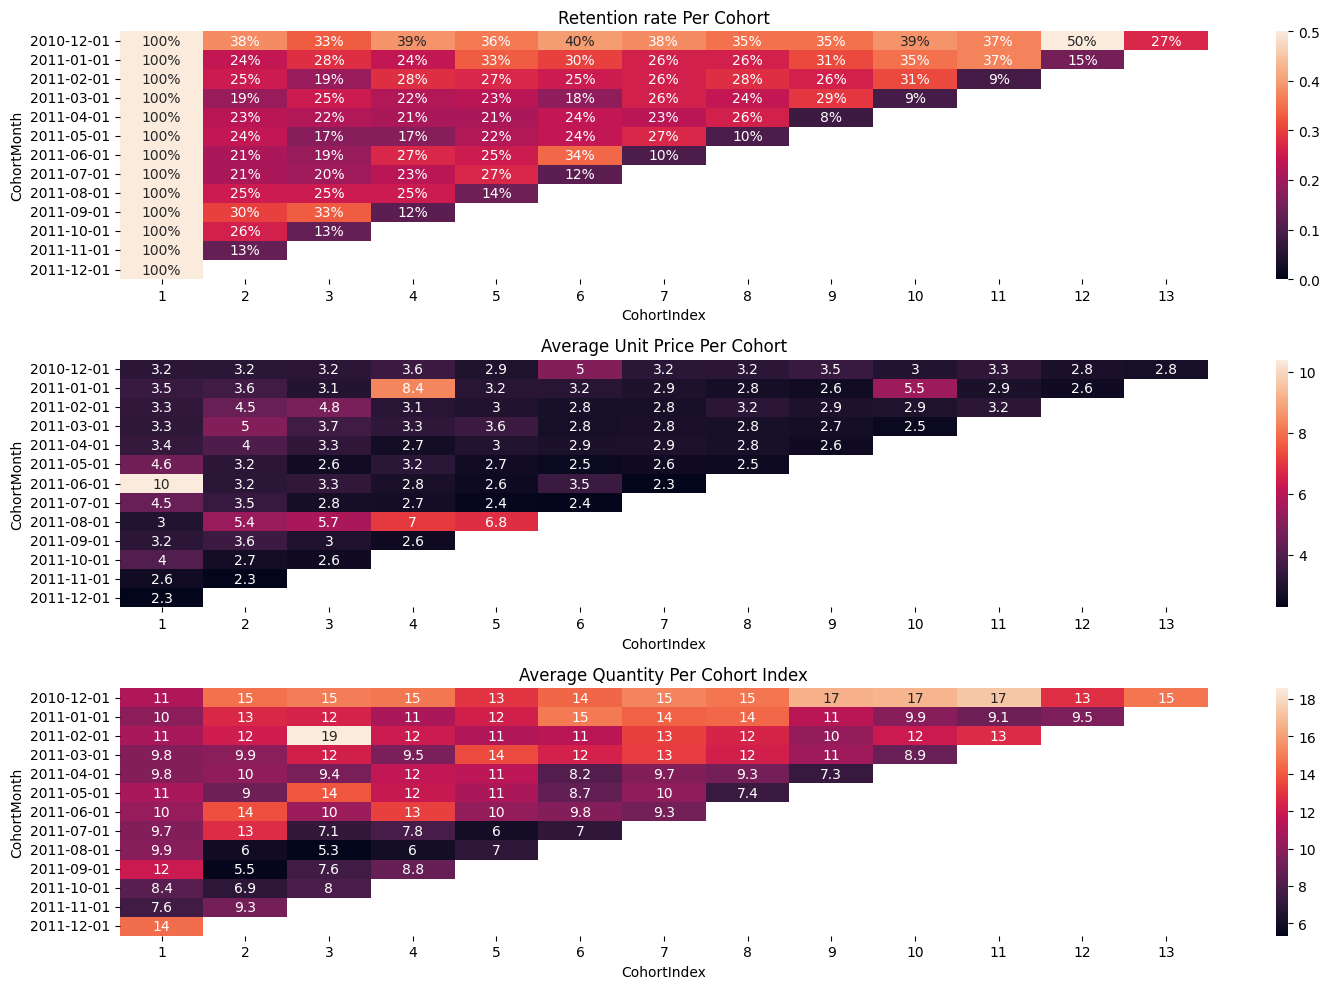

In [153]:
#----------------------------------------------------------------------------------------------------
# Plotting Heatmaps for Visualization
#----------------------------------------------------------------------------------------------------

plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
ax = sns.heatmap(retention, annot=True, fmt='.0%', vmin=0, vmax=0.5 )
ax.set_yticklabels(retention.index.date)
ax.set_title('Retention rate Per Cohort')

plt.subplot(3,1,2)
ax = sns.heatmap(average_cohort_price, annot=True)
ax.set_title('Average Unit Price Per Cohort')
ax.set_yticklabels(average_cohort_price.index.date)

plt.subplot(3,1,3)
ax = sns.heatmap(average_cohort_quantity, annot=True)
ax.set_title('Average Quantity Per Cohort Index')
ax.set_yticklabels(average_cohort_quantity.index.date)

plt.tight_layout()
plt.show()

## INFERENCES 
    # Customer Retention Rate Drops over time 
    # Quantity of Purchased items is higher during Holiday Season but remains fairly contant during the rest of the year
    # Bigger Purchases are made during the Holiday Season. Bigger Holiday Discounts could be the reason 

    

# RECENCY FREQUENCY AND MONETARY SEGMENTATION 


## RFM SEGMENTATION:  
    Recency: How recent was a customer's last purchase 
    Frequency: How many times the cutomer has purchased items in the last 12 months 
    monetary: How much amount the customer has spent in the last 12 months

## CALCULATING RFM VALUES 

In [159]:
# Calculate one year date range from the latest data 

earliest_date = df['Date'].min()
end_date = df['Date'].max()

print(f'Earliest date: {earliest_date} \nLatest Date: {end_date} ')

# Filtering One Year data from original df 
start_date = end_date - pd.to_timedelta(364, unit='d')

df_rfm = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

print(f"RFM Start Date : {df_rfm['Date'].min()} \nRFM End Date: {df_rfm['Date'].max()}")



Earliest date: 2010-12-01 
Latest Date: 2011-12-09 
RFM Start Date : 2010-12-10 
RFM End Date: 2011-12-09


In [164]:
# Creating a Hypothetical snapshot date 
snapshot_date = end_date + pd.to_timedelta(1, unit='d')

# calculating Rececny, frequency and Monetary value for each Customer 

df_rfm = df_rfm.groupby(['CustomerID']).agg({
    'Date': lambda x : (snapshot_date-x.max()).days,
    'InvoiceNo': 'count', 
    'TotalAmount': 'sum'
})

df_rfm.rename(columns={
    'Date': 'Recency', 
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary' }, inplace=True)

In [165]:
df_rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,151,3598.21
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


## BUILDING RFM SEGMENTS 

Assigning a Quantile to each Customer 

In [166]:
# Obtaining Quantile for each customer 
def get_quantile(df, column, start_n_quantiles, end_n_quantiles, step=1):
    category_labels = range(start_n_quantiles, end_n_quantiles, step)
    quantiles = pd.qcut(df[column], q=abs(end_n_quantiles-start_n_quantiles), labels=category_labels)
    
    df = df.assign(name=quantiles.values)
    
    new_column_name =   column + '_Q'
    
    return df.rename(columns={'name': new_column_name})
    

In [179]:
df_rfm_quantile = df_rfm.copy()

df_rfm_quantile = get_quantile(df_rfm_quantile, 'Recency', 4,0,-1)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'Frequency', 1,5,1)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'Monetary', 1,5,1)


df_rfm_quantile.head()

,Recency,Frequency,Monetary,Recency_Q,Frequency_Q,Monetary_Q
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,3,151,3598.21,4,4,4
12348.0,76,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,311,17,334.40,1,1,2


Calculate RFM score 

In [185]:
def join_rfm(x):
    return int(str(x['Recency_Q']) + str(x['Frequency_Q']) + str(x['Monetary_Q']))

In [186]:
df_rfm_quantile['RFM_score'] = df_rfm_quantile.apply(join_rfm, axis=1)

df_rfm_quantile.head()

,Recency,Frequency,Monetary,Recency_Q,Frequency_Q,Monetary_Q,RFM_score
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,111
12347.0,3,151,3598.21,4,4,4,444
12348.0,76,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,311,17,334.40,1,1,2,112


In [195]:
df_rfm_quantile['RFM_points'] = df_rfm_quantile[['Recency_Q','Frequency_Q','Monetary_Q']].sum(axis=1)

df_rfm_quantile.head()

,Recency,Frequency,Monetary,Recency_Q,Frequency_Q,Monetary_Q,RFM_score,RFM_points
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,3,151,3598.21,4,4,4,444,12
12348.0,76,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,311,17,334.40,1,1,2,112,4


Analysing RFM Table

In [196]:
df_rfm_quantile.groupby('RFM_score').size().sort_values(ascending=False)[:10]

RFM_score
444    449
111    391
344    212
122    200
333    174
211    174
222    169
233    157
433    148
311    121
dtype: int64

In [197]:
df_rfm_quantile[df_rfm_quantile['RFM_score'] ==111].head()
df_rfm_quantile[df_rfm_quantile['RFM_score'] ==444].head()


,Recency,Frequency,Monetary,Recency_Q,Frequency_Q,Monetary_Q,RFM_score,RFM_points
CustomerID,,,,,,,,
12347.0,3,151,3598.21,4,4,4,444,12
12359.0,8,254,6245.53,4,4,4,444,12
12362.0,4,274,5154.58,4,4,4,444,12
12388.0,16,100,2780.66,4,4,4,444,12
12395.0,16,147,2652.18,4,4,4,444,12


In [198]:
# Summary metrics Per RFM Score 

df_rfm_quantile.groupby('RFM_points').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': ['mean', 'count']
}).round(1)

Recency Frequency Monetary      
              mean      mean     mean count
RFM_points                                 
3            247.4       7.9    106.3   391
4            163.9      14.0    221.7   375
5            146.3      20.7    348.7   507
6             87.8      28.4    487.6   460
7             80.6      39.4    726.4   436
8             57.8      54.8    958.9   464
9             44.1      77.4   1351.5   406
10            30.6     112.8   1800.2   437
11            20.4     197.1   4069.6   370
12             6.8     365.0   8612.1   449

## Creating Custom Segments 

In [199]:
def segment_me(df):
    if df['RFM_points'] >=9:
        return '1.Gold'
    elif (df['RFM_points'] >= 5) and (df['RFM_points'] < 9):
        return '2.Silver'
    else:
        return '3.Bronze'

In [203]:
df_rfm_quantile['Segment'] = df_rfm_quantile.apply(segment_me, axis=1)

In [205]:
df_rfm_quantile.head()

,Recency,Frequency,Monetary,Recency_Q,Frequency_Q,Monetary_Q,RFM_score,RFM_points,Segment
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,3.Bronze
12347.0,3,151,3598.21,4,4,4,444,12,1.Gold
12348.0,76,31,1797.24,2,2,4,224,8,2.Silver
12349.0,19,73,1757.55,3,3,4,334,10,1.Gold
12350.0,311,17,334.40,1,1,2,112,4,3.Bronze


In [208]:
df_rfm_segment = df_rfm_quantile.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': ['mean', 'count']
}).round(1)

df_rfm_segment

Recency Frequency Monetary      
            mean      mean     mean count
Segment                                  
1.Gold      25.2     191.0   4036.1  1662
2.Silver    94.5      35.4    622.8  1867
3.Bronze   206.5      10.8    162.8   766

# Data Preprocessing for clustering

Checking if the dataset has a Neutral Skew

In [211]:
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print(f"{column}'s:  Skew:{skew}, : {skewtest} ")
    return 
    
    
    

Recency's:  Skew:1.2444937290057807, : SkewtestResult(statistic=26.458726592189453, pvalue=2.895613835933345e-154) 
Frequency's:  Skew:18.12183686440274, : SkewtestResult(statistic=83.17480537059672, pvalue=0.0) 
Monetary's:  Skew:21.459150114865704, : SkewtestResult(statistic=86.8803096289234, pvalue=0.0) 


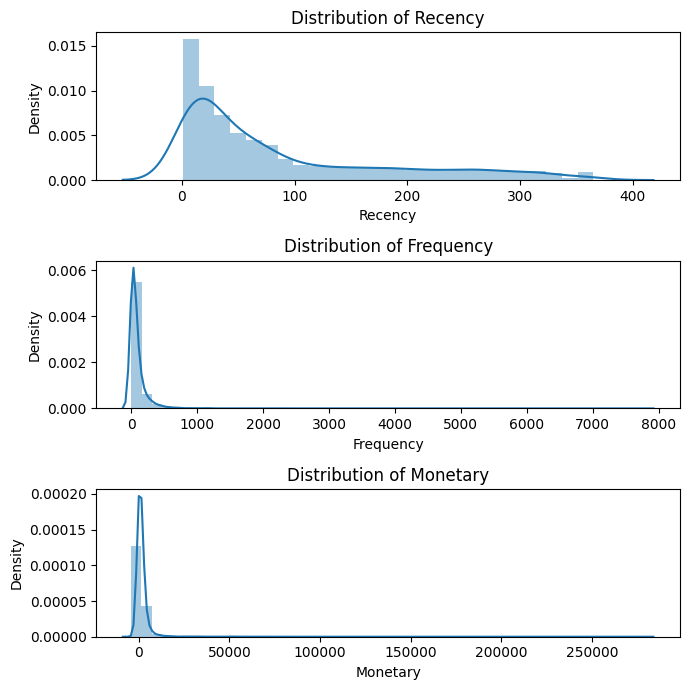

In [219]:
plt.figure(figsize=(7,7))

plt.subplot(3,1,1)
check_skew(df_rfm,'Recency')

plt.subplot(3,1,2)
check_skew(df_rfm,'Frequency')

plt.subplot(3,1,3)
check_skew(df_rfm,'Monetary')

plt.tight_layout()
plt.show()

In [220]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,1861.569840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,290.260000
50%,48.000000,41.000000,644.240000
75%,134.000000,99.000000,1585.915000
max,365.000000,7793.000000,279489.020000


    RFM dataframe exhibits a right skew and unequal average Standard Deviation of Recency, Frequency and Monetary which goes against the
    assumptions made for K-means Clustering

    Applying Logarithmic Transform the data to obtain a Neutral Skew

    If Negative values are found, absolute lowest negative value will be added to each observation followed by addidition of a constant(1 in this case)

In [226]:
df_rfm_log = df_rfm.copy()

# Data preprocessing for negative values 
df_rfm_log['Monetary'] = (df_rfm_log['Monetary'] - df_rfm_log['Monetary'].min()) + 1

df_rfm_log.describe() 

,Recency,Frequency,Monetary
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,6150.199840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,1.000000
25%,17.000000,17.000000,4578.890000
50%,48.000000,41.000000,4932.870000
75%,134.000000,99.000000,5874.545000
max,365.000000,7793.000000,283777.650000


Recency's:  Skew:-0.4547480558293254, : SkewtestResult(statistic=-11.634943795553278, pvalue=2.7377040764655793e-31) 
Frequency's:  Skew:-0.239827897754714, : SkewtestResult(statistic=-6.339202735355403, pvalue=2.3095716421771635e-10) 
Monetary's:  Skew:0.12898570622951744, : SkewtestResult(statistic=3.4428751888302336, pvalue=0.0005755648779652132) 


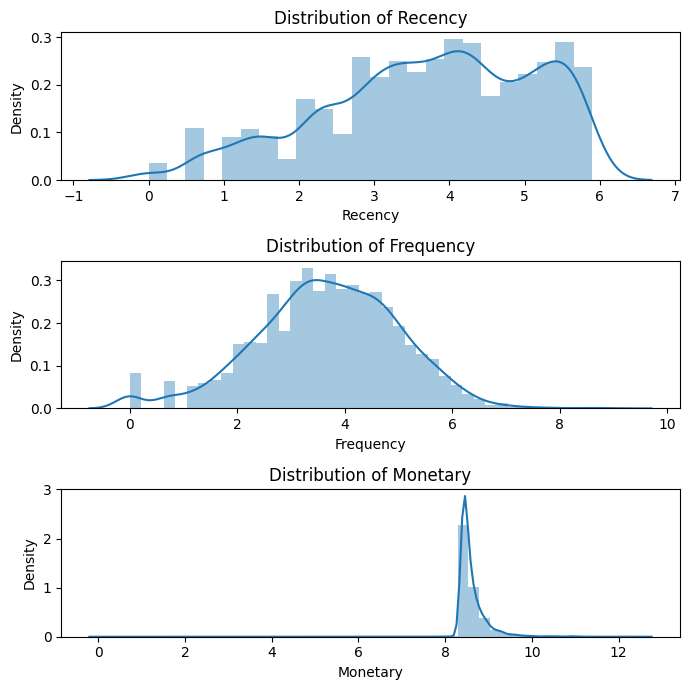

In [287]:
# Transforming Skewed data with Logarithmic Transformation
#df_rfm_log = np.log(df_rfm_log)

plt.figure(figsize=(7,7))

plt.subplot(3,1,1)
check_skew(df_rfm_log, 'Recency')

plt.subplot(3,1,2)
check_skew(df_rfm_log, 'Frequency')

plt.subplot(3,1,3)
check_skew(df_rfm_log, 'Monetary')

plt.tight_layout()
plt.savefig('TransformedRFMData.png', format='png', dpi=1000)
plt.show()


Centering and Scaling

In [236]:
scaler = StandardScaler()
scaler.fit(df_rfm_log)
df_rfm_scaled = scaler.transform(df_rfm_log)

df_rfm_scaled = pd.DataFrame(df_rfm_scaled, index=df_rfm_log.index, columns=df_rfm_log.columns)


In [238]:
df_rfm_scaled.describe().round(2)

,Recency,Frequency,Monetary
count,4295.00,4295.00,4295.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.67,-2.76,-23.89
25%,-0.64,-0.63,-0.51
50%,0.10,0.03,-0.30
75%,0.84,0.69,0.18
max,1.55,3.98,10.93


# K-Means clustering

Finding Optimal clusters using Elbow method and Silhoutte score

In [288]:
def optimal_clusters(df, start=2, end=11):
    n_clu = []
    inertia = []
    km_ss = []
    
    for n_clusters in range(start, end):
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(df)
        
        inertia_score = round(kmeans.inertia_, 2)
        silhouette_score_avg = round(silhouette_score(df, labels, random_state=42), 2)
        
        n_clu.append(n_clusters)
        inertia.append(inertia_score)
        km_ss.append(silhouette_score_avg)
        
        
        if n_clusters == end-1:
            plt.figure(figsize=(7,7))
            
            plt.subplot(2,1,1)
            plt.title('With in cluster Sum of Squares / Inertia')
            plt.xlabel('Clusters')
            plt.ylabel('WCSS')
            sns.pointplot(x=n_clu, y=inertia)
            
            plt.subplot(2,1,2)
            plt.title('Silhoutte Scores')
            plt.xlabel('Clusters')
            plt.ylabel('Silhoutte score')
            sns.pointplot(x=n_clu, y=km_ss)
            
            plt.tight_layout()

        
    
        

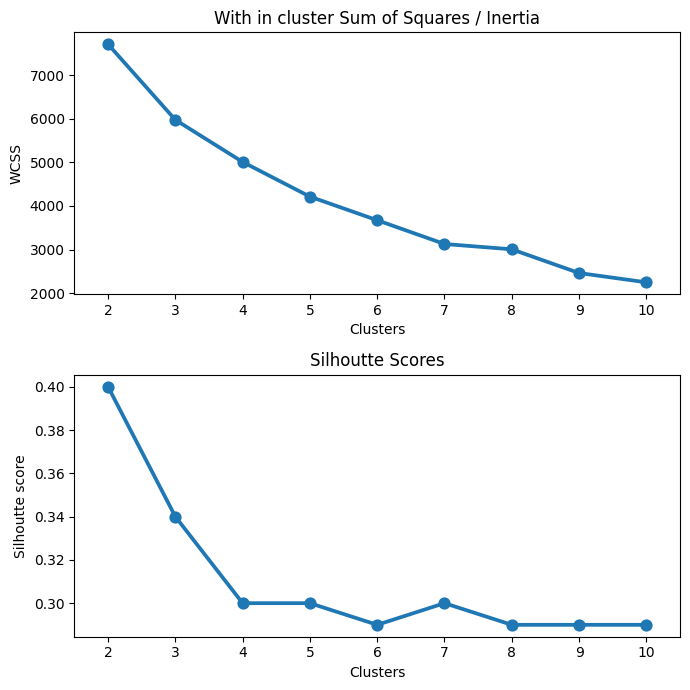

In [289]:
optimal_clusters(df_rfm_scaled)
plt.savefig('OptimalClustersElowSilhoutte.png', format='png', dpi=1000)
plt.show()


Based on the Silhoutte Scores and WCSS, Optimal number of Clusters obtained is 4   

Implementig KMeans Clustering

In [260]:
def create_kmeans(scaled_df, clusters, original_df):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    kmeans.fit(scaled_df)
    
    # Cluster labels
    cluster_labels = kmeans.labels_
    
    # Creating column to assign cluster label in original dataset
    df_new = original_df.assign(Cluster=cluster_labels)
    
    # Initialize TSNE
    model = TSNE(random_state=42)
    transformed = model.fit_transform(df_new)
    
    # Plotting T-SNE
    plt.title(f'Flattened Graph of {clusters} Clusters')
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette='Set2')
    
    return df_new
    
    
    

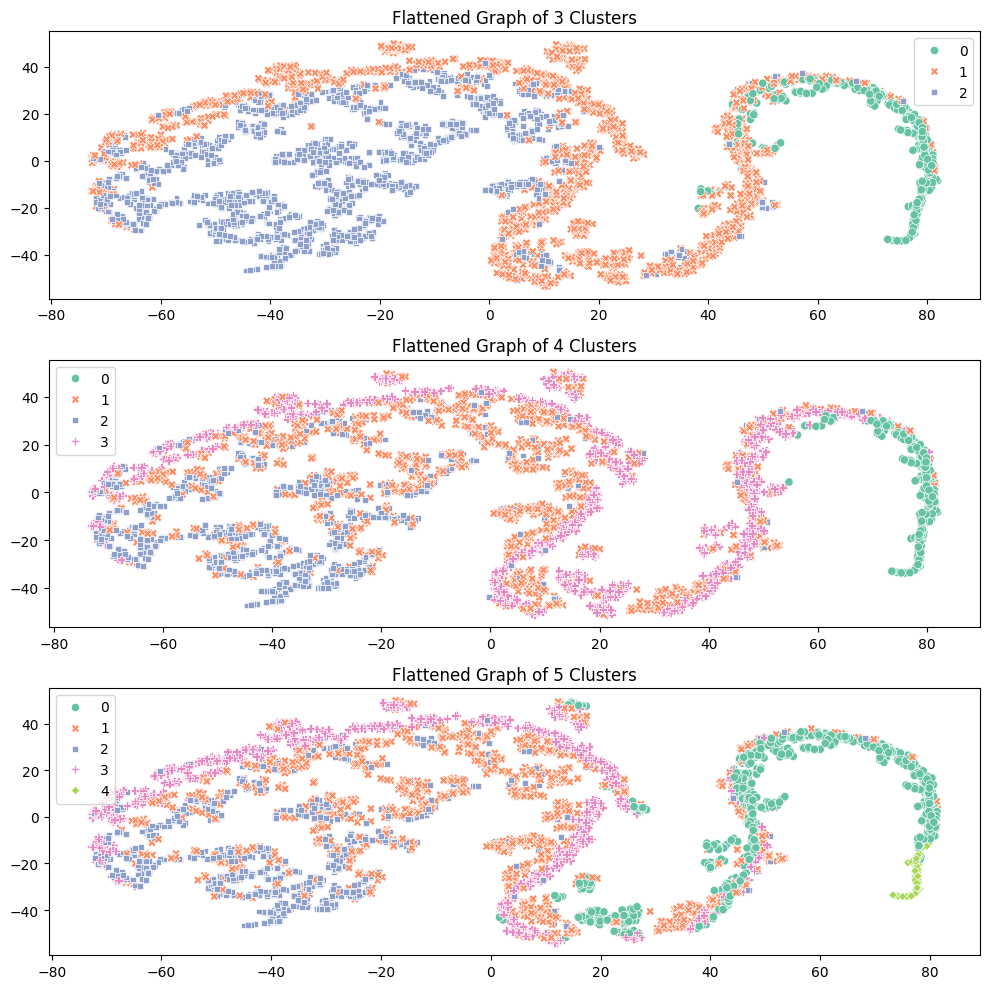

In [266]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
df_rfm_k3 = create_kmeans(df_rfm_scaled, 3, df_rfm)

plt.subplot(3,1,2)
df_rfm_k4 = create_kmeans(df_rfm_scaled, 4, df_rfm)

plt.subplot(3,1,3)
df_rfm_k5 = create_kmeans(df_rfm_scaled, 5, df_rfm)

plt.tight_layout()

plt.savefig('Flattend Clusters.png', format='png', dpi=1000)

# Building Customer Personas

Summary Statistics

In [267]:
def calculate_rfm_values(df):
    '''
    Calculate aggregate RFM values for each cluster 
    
    '''
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean', 
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new
        

In [268]:
calculate_rfm_values(df_rfm_k3)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          14.0     393.0  10611.0   447
1          34.0      91.0   1278.0  1921
2         159.0      21.0    414.0  1927

In [269]:
calculate_rfm_values(df_rfm_k4)


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          14.0     442.0  13125.0   334
1         115.0      57.0    902.0  1517
2         160.0      10.0    285.0  1106
3          15.0     110.0   1442.0  1338

In [270]:
calculate_rfm_values(df_rfm_k5)


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          19.0     222.0   3205.0   840
1         128.0      55.0    848.0  1381
2         169.0       9.0    261.0   973
3          17.0      48.0    742.0   992
4          12.0     672.0  28825.0   109

# Snake plots 

In [4]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    '''
    Transform dataframe and plot snakeplot
    '''
    # Transform df_normal as df and add cluster column
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm.index, 
                                       columns=df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

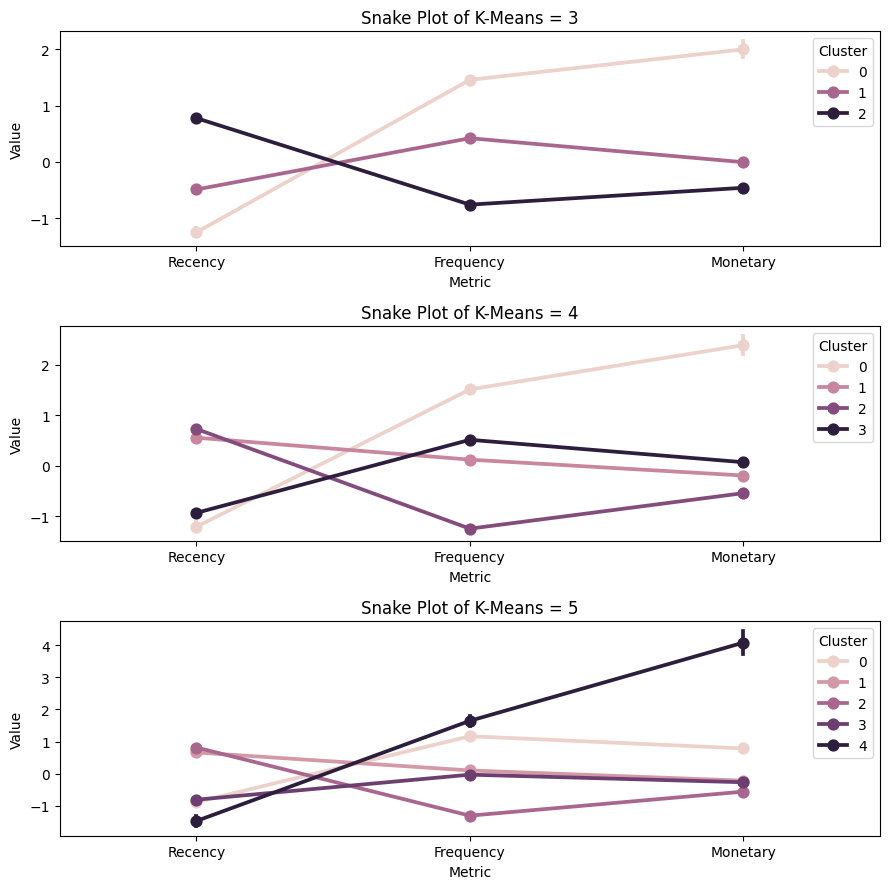

In [7]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(df_rfm_scaled, df_rfm_k3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(df_rfm_scaled, df_rfm_k4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(df_rfm_scaled, df_rfm_k5, df_rfm)

plt.tight_layout()
plt.savefig('../reports/figures/Cluster_snake_plots.png', format='png')

Importance of Segment Attributes 

In [279]:
def relative_importance(df_rfm_kmeans, df_rfm_orifinal):
    '''
    Calcluate relative Importance of Segment attributes and plot a heatmap 
    
    '''
    cluster_avg = df_rfm_kmeans.groupby('Cluster').mean()
    
    population_avg = df_rfm.mean()
    
    relative_importance = cluster_avg/population_avg-1
    
    sns.heatmap(data=relative_importance, annot=True, fmt= '.2f')
    
    return 
    

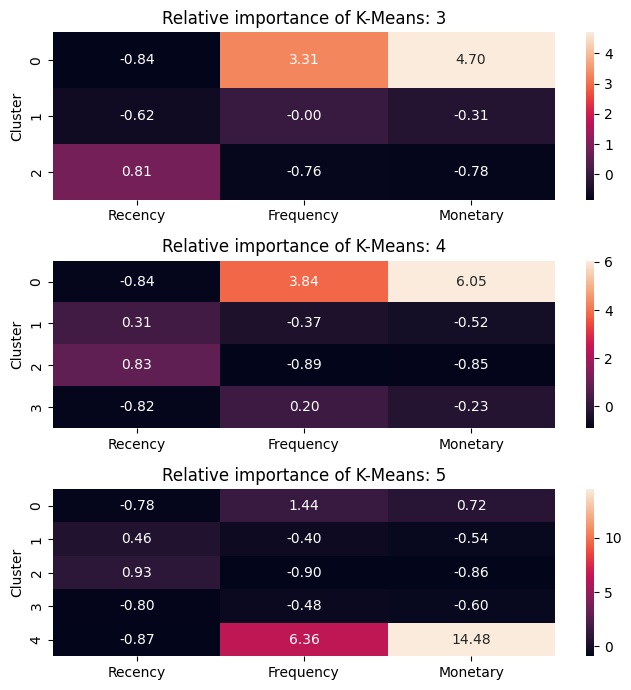

In [281]:
plt.figure(figsize=(7,7))

plt.subplot(3,1,1)
plt.title('Relative importance of K-Means: 3')
relative_importance(df_rfm_k3, df_rfm)


plt.subplot(3,1,2)
plt.title('Relative importance of K-Means: 4')
relative_importance(df_rfm_k4, df_rfm)


plt.subplot(3,1,3)
plt.title('Relative importance of K-Means: 5')
relative_importance(df_rfm_k5, df_rfm)

plt.tight_layout()

plt.savefig('Relative importance of K-Means Clusters.png', format='png', dpi=1000)

In [294]:
pd.to_pickle(df_rfm, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm.pkl')
pd.to_pickle(df_rfm_k3, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_k3.pkl')
pd.to_pickle(df_rfm_k4, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_k4.pkl')
pd.to_pickle(df_rfm_k5, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_k5.pkl')
pd.to_pickle(df_rfm_log, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_log.pkl')
pd.to_pickle(df_rfm_quantile, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_quantile.pkl')
pd.to_pickle(df_rfm_scaled, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_scaled.pkl')
pd.to_pickle(df_rfm_segment, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_segment.pkl')
pd.to_pickle(df_rfm_log, '../PYTHON PROJECT - Customer Segmentation/data/processed/df_rfm_log.pkl')




In [296]:
pd.to_pickle(df, '../PYTHON PROJECT - Customer Segmentation/data/processed/df.pkl')

In [ ]:
df